In [118]:
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import datetime

import logging
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

import warnings
warnings.simplefilter(action="ignore", category=[SettingWithCopyWarning, DeprecationWarning])

import spacy

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import gensim

import tomotopy as tp

import yfinance as yf

#######################
from utils.preprocesing_token import *
from utils.hdp_training import *

# Step 1: data loading

### Get company description information data

In [36]:
# load the ticker and gvkey data
comp_info = pd.read_csv('data/tick_gvkey_gics.csv')

# get the unique gvkeys
compdesc_info = comp_info[['conm', 'gvkey', 'tic', 'gind', 'ggroup']]
compdesc_info = compdesc_info.drop_duplicates(subset='gvkey')

# convert gvkey to string for 6 digits
compdesc_info = compdesc_info.astype(str)
compdesc_info['gvkey'] = compdesc_info['gvkey'].apply(lambda x: x.zfill(6))

### Get q&a data of earnings call transcripts

In [3]:
# read transcript data
pru_data = pd.read_parquet(
    'data/sp500_cc_transcripts_2014_2023.parquet', engine='pyarrow'
    )

# filter out the qna_transcript for QnA only (ID = 3 or 4)
qna_transcript = pru_data[pru_data['transcriptComponentTypeId'] != 2].groupby(['gvkey', 'doc_date'])['componentText'].apply(lambda x: ' '.join(x)).reset_index()

# merge qna_transcript with compdesc_info on gvkey to get the company name and tickers
qna_transcript = qna_transcript.merge(compdesc_info, on='gvkey', how='left')

# Step 2: data preprocessing

In [8]:
# # using spacy to tokenize the text
# nlp = spacy.load("en_core_web_sm")
# removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
# consider_only = ['NOUN']

# # tokenize and lemmatize the text
# tokens = []
# for qna in tqdm(nlp.pipe(qna_transcript['componentText']), total=len(qna_transcript)):
#    proj_tok = [token.lemma_.lower() for token in qna if token.pos_ not in removal and not token.is_stop and token.is_alpha]
#    tokens.append(proj_tok)

# # make a bigram for better analysis
# bigram = gensim.models.phrases.Phrases(tokens)
# tokens = [bigram[line] for line in tokens]
# tokens = [bigram[line] for line in tokens]

In [ ]:
nlp = spacy.load("en_core_web_sm")
tokens = tokenize_text(qna_transcript, nlp, noun=True)
with open('data/qna_tokens_for_topic.pkl', 'wb') as f:
    pickle.dump(tokens, f)
with open('data/qna_noun_tokens_for_topic.pkl', 'wb') as f:
    pickle.dump(tokens, f)

In [48]:
# # save the tokens to pickle file
# with open('data/qna_tokens_for_topic.pkl', 'wb') as f:
#     pickle.dump(tokens, f)

In [ ]:
# load tokens from pickle file
with open('data/qna_tokens_for_topic.pkl', 'rb') as f:
    tokens = pickle.load(f)

In [6]:
# # only consider nouns that appear in the transcript
# nlp = spacy.load("en_core_web_sm")
# consider_only = ['NOUN']

# tokens = []
# for qna in tqdm(nlp.pipe(qna_transcript['componentText']), total=len(qna_transcript)):
#    proj_tok = [token.lemma_.lower() for token in qna if token.pos_ in consider_only and not token.is_stop and token.is_alpha]
#    tokens.append(proj_tok)

# # make a bigram for better analysis
# bigram = gensim.models.phrases.Phrases(tokens)
# tokens = [bigram[line] for line in tokens]
# tokens = [bigram[line] for line in tokens]

100%|██████████| 23412/23412 [5:06:51<00:00,  1.27it/s]  


In [7]:
# # save the tokens to pickle file
# with open('data/qna_noun_tokens_for_topic.pkl', 'wb') as f:
#     pickle.dump(tokens, f)

In [2]:
# load tokens from pickle file
with open('data/qna_noun_tokens_for_topic.pkl', 'rb') as f:
    tokens = pickle.load(f)

In [9]:
# # add tokenized text to the dataframe
# qna_transcript['qna tokens'] = tokens

# # get the quarter of the transcript
# qna_transcript['doc_date'] = pd.to_datetime(qna_transcript['doc_date'])
# qna_transcript['doc_quarter'] = qna_transcript['doc_date'].dt.to_period('Q')

In [ ]:
qna_transcript = add_tokenized_text(qna_transcript, tokens)
# save the dataframe to parquet file
qna_transcript.to_parquet('data/qna_transcript_noun_token.parquet', engine='pyarrow')
# save the dataframe to parquet file
qna_transcript.to_parquet('data/qna_transcript_token.parquet', engine='pyarrow')

In [10]:
# # save the dataframe to parquet file
# qna_transcript.to_parquet('data/qna_transcript_noun_token.parquet', engine='pyarrow')

/Users/yun-wonje/anaconda3/envs/dsc_prudential/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/Users/yun-wonje/anaconda3/envs/dsc_prudential/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/Users/yun-wonje/anaconda3/envs/dsc_prudential/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/Users/yun-wonje/anaconda3/envs/dsc_prudential/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a 

In [3]:
# code to load pre-tokenized noun data
qna_transcript = pd.read_parquet(
    'data/qna_transcript_noun_token.parquet', engine='pyarrow'
    )

In [15]:
# # save the dataframe to parquet file
# qna_transcript.to_parquet('data/qna_transcript_token.parquet', engine='pyarrow')

/Users/yun-wonje/anaconda3/envs/dsc_prudential/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/Users/yun-wonje/anaconda3/envs/dsc_prudential/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/Users/yun-wonje/anaconda3/envs/dsc_prudential/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/Users/yun-wonje/anaconda3/envs/dsc_prudential/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a 

In [2]:
# code to load pre-tokenized data
qna_transcript = pd.read_parquet(
    'data/qna_transcript_token.parquet', engine='pyarrow'
    )

In [4]:
quarter_lst = qna_transcript['doc_quarter'].unique().tolist()

## Step 3: Hierarchical Dirichlet Process (HDP) for topic modeling

In [5]:
# hdp_model_lst = []
# for quarter in quarter_lst:
#     print(quarter)
#     term_weight = tp.TermWeight.PMI
#     hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1,
#                     alpha=0.1, initial_k=10, seed=1234)
#     word_list_lemmatized = qna_transcript[qna_transcript['doc_quarter']==quarter]

#     for vec in word_list_lemmatized['qna tokens']:
#         hdp.add_doc(vec)
#     for i in range(0, 1000, 100):
#         hdp.train(100, workers=1)
#         print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
#     hdp_model_lst.append(hdp)
#     print('===========================================================')

2014Q1
Iteration: 0	Log-likelihood: -7.4992539088175425	Num. of topics: 10
Iteration: 100	Log-likelihood: -7.468456628173189	Num. of topics: 10
Iteration: 200	Log-likelihood: -7.458430124875664	Num. of topics: 10
Iteration: 300	Log-likelihood: -7.4500210024114075	Num. of topics: 10
Iteration: 400	Log-likelihood: -7.441623640359717	Num. of topics: 10
Iteration: 500	Log-likelihood: -7.434829213831118	Num. of topics: 10
Iteration: 600	Log-likelihood: -7.43610897868101	Num. of topics: 10
Iteration: 700	Log-likelihood: -7.4275579116528805	Num. of topics: 10
Iteration: 800	Log-likelihood: -7.425329895249607	Num. of topics: 10
Iteration: 900	Log-likelihood: -7.432688350924716	Num. of topics: 10
2014Q2
Iteration: 0	Log-likelihood: -7.4373249822471745	Num. of topics: 11
Iteration: 100	Log-likelihood: -7.41656153460159	Num. of topics: 11
Iteration: 200	Log-likelihood: -7.406334309547729	Num. of topics: 11
Iteration: 300	Log-likelihood: -7.402794193852455	Num. of topics: 12
Iteration: 400	Log-lik

In [ ]:
hdp_model_lst = train_hdp_model(qna_transcript, quarter_lst)
# save the list of models to file
for i, item in enumerate(hdp_model_lst):
    # write each item on a new line
    item.save(f'hdp_models/hdp_model_{quarter_lst[i]}.bin')

In [38]:
# # save the list of models to file
# for i, item in enumerate(hdp_model_lst):
#     # write each item on a new line
#     item.save(f'hdp_models/hdp_model_{quarter_lst[i]}.bin')

In [6]:
# load the list of models from file
hdp_model_lst = []
for quarter in quarter_lst:
    mdl = tp.HDPModel.load(f'hdp_models/hdp_model_{quarter}.bin')
    hdp_model_lst.append(mdl)

In [7]:
# def get_hdp_topics(hdp, top_n=10):
#     '''Wrapper function to extract topics from trained tomotopy HDP model 
    
#     ** Inputs **
#     hdp:obj -> HDPModel trained model
#     top_n: int -> top n words in topic based on frequencies
    
#     ** Returns **
#     topics: dict -> per topic, an arrays with top words and associated frequencies 
#     '''
    
#     # Get most important topics by # of times they were assigned (i.e. counts)
#     sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

#     topics=dict()
    
#     # For topics found, extract only those that are still assigned
#     for k in sorted_topics:
#         if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
#         topic_wp =[]
#         for word, prob in hdp.get_topic_words(k, top_n=top_n):
#             topic_wp.append((word, prob))

#         topics[k] = topic_wp # store topic word/frequency array
        
#     return topics

# def get_inferred_topic(hdp, doc):
#     '''Wrapper function to extract inferred topic for a given document
    
#     ** Inputs **
#     hdp:obj -> HDPModel trained model
#     doc: list -> list of words in document
#     ** Returns **
#     topics: dict -> per topic, an arrays with top words and associated frequencies 
#     '''
#     # Get most important topics by # of times they were assigned (i.e. counts)
#     doc_inst = hdp.make_doc(doc)
#     real_vecs = []
#     for k, vec_k in enumerate(hdp.infer(doc_inst)[0]):
#         if not hdp.is_live_topic(k): continue
#         real_vecs.append(vec_k)

#     inferred_topics = (np.array(real_vecs), hdp.infer(doc_inst)[1])
#     return inferred_topics

def prepare_pyldavis_hdp(hdp):
    '''Wrapper function to prepare data for pyLDAvis from trained tomotopy HDP model

    ** Inputs **
    hdp:obj -> HDPModel trained model

    ** Returns **
    prepared_data: dict -> dictionary with topic-term and doc-topic distributions
    '''
    topic_term_dists = np.stack(                                 # step 1
            [hdp.get_topic_word_dist(k) for k in range(hdp.live_k)]
        )
    # make the rows sum to 1
    topic_term_dists /= topic_term_dists.sum(axis=1, keepdims=True)
    doc_topic_dists = np.stack(                                  # step 2
            [doc.get_topic_dist()[:hdp.live_k] for doc in hdp.docs]
        )
    # make the rows sum to 1
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in hdp.docs]) # step 3
    vocab = list(hdp.used_vocabs)                                # step 4
    term_frequency = hdp.used_vocab_freq                         # step 5

    # try mds = 'tsne' or 'mmds' for a different view
    prepared_data = pyLDAvis.prepare(
            topic_term_dists, 
            doc_topic_dists, 
            doc_lengths, 
            vocab, 
            term_frequency,
            start_index=0, 
            sort_topics=False 
        )
    return prepared_data


In [7]:
# earnings_call_qt_list = []

# for i, hdp in tqdm(enumerate(hdp_model_lst), total=len(hdp_model_lst)):
#     topics = get_hdp_topics(hdp, top_n=30)
#     # get the word list lemmatized for the quarter, or split the entire dataframe by quarters
#     word_list_lemmatized = qna_transcript[qna_transcript['doc_quarter']==quarter_lst[i]].reset_index(drop=True)

#     # get the inferred topics for each documents
#     topic_allocation = []
#     for wd_lst in range(len(word_list_lemmatized)):
#         doc = word_list_lemmatized['qna tokens'].iloc[wd_lst]
#         inferred_topics = get_inferred_topic(hdp, doc)
#         # add the index of largest index of inferred_topics[0] to topic_allocation
#         topic_allocation.append(np.argmax(inferred_topics[0]))
    
#     word_list_lemmatized.loc[:, 'topic_allocation'] = topic_allocation
#     word_list_lemmatized = word_list_lemmatized.dropna(subset = ['tic'])
#     earnings_call_qt_list.append(word_list_lemmatized)


100%|██████████| 40/40 [07:03<00:00, 10.60s/it]


In [ ]:
earnings_call_qt_list = get_earnings_call_w_topics(hdp_model_lst, qna_transcript)
# save earnings_call_qt_list to file
with open ('data/earnings_call_qt_list.pkl', 'wb') as f:
    pickle.dump(earnings_call_qt_list, f)

In [40]:
# # save earnings_call_qt_list to file
# with open ('data/earnings_call_qt_list.pkl', 'wb') as f:
#     pickle.dump(earnings_call_qt_list, f)

In [8]:
# load earnings_call_qt_list from file
with open ('data/earnings_call_qt_list.pkl', 'rb') as f:
    earnings_call_qt_list = pickle.load(f)

### Get the count of the top topic words for each quarter

In [73]:
# for each hdp models, get the top 10 words for each topic
top_words = []
for i, hdp in enumerate(hdp_model_lst):
    top_words.append(get_hdp_topics(hdp, top_n=10))

In [74]:
total_top_wrds_by_qt = []
for i in range(len(top_words)):
    qt_top_wrds = []
    for word_scr_lst in top_words[i].values():
        for wrd, scr in word_scr_lst:
            qt_top_wrds.append(wrd)
    total_top_wrds_by_qt.append(qt_top_wrds)

In [75]:
total_top_words = []
for num_periods in range(len(top_words)):
    for key, value in top_words[num_periods].items():
        for words in value:
            total_top_words.append(words[0])

total_top_words = set(total_top_words)
total_top_words = list(total_top_words)
print(len(total_top_words))

# for each list in total_top_wrds_by_qt, get the count of the words in the list that appears in total_top_words
# and add as a column to a new dataframe
word_count_df = pd.DataFrame()
for i in range(len(total_top_wrds_by_qt)):
    word_count = []
    for word in total_top_words:
        word_count.append(total_top_wrds_by_qt[i].count(word))
    word_count_df[quarter_lst[i]] = word_count
word_count_df.index = total_top_words


539


In [132]:
# for each row in word_count_df, remove the rows with more than half of the values as 0
trimmed_word_count_df = word_count_df.loc[(word_count_df!=0).sum(axis=1) > 10]
trimmed_word_count_df.to_csv('data/quarterly_trimmed_word_count.csv')

In [77]:
# sum the columns of word_count_df based on the year of the column
yrly_word_count_df = word_count_df.copy()
yrly_word_count_df.columns = word_count_df.columns.to_timestamp().to_period('Y')
# groupby columns and sum
yrly_word_count_df = yrly_word_count_df.transpose().groupby(level=0).sum().transpose()

In [134]:
trim_yrly_word_count_df = yrly_word_count_df.loc[(yrly_word_count_df!=0).sum(axis=1) > 3]
trim_yrly_word_count_df.to_csv('data/yearly_trimmed_word_count.csv')

# Step 4: Portfolio generation and evaluation for the topics generates

In [27]:
def get_topic_all_tic_list(df):
    '''Wrapper function to get the list of 'tic' with the same topic allocation
    Input:
    df: dataframe -> dataframe with 'tic' and 'topic_allocation' columns
    ** Returns **
    same_topic_tic_lst: list -> list of 'tic' with the same topic allocation
    '''
    same_topic_tic_lst = []
    for i in df['topic_allocation'].unique():
        same_topic_tic = df[df['topic_allocation'] == i]['tic'].unique().tolist()
        same_topic_tic_lst.append(same_topic_tic)
    return same_topic_tic_lst

# get the stock price for the given 'doc_quarter' for the given 'tic's
def get_stock_price(tic_lst, start, end):
    '''Function to get the stock price for the given 'doc_quarter' for the given 'tic's
    
    ** Inputs **
    tic_lst: list -> list of 'tic's
    quarter: str -> quarter in 'YYYY-Qn' format
    
    ** Returns **
    stock_price: DataFrame -> dataframe with stock price for the given 'tic's
    '''
    stock_price = pd.DataFrame()
    for tic in tic_lst:
        try:
            stock = yf.download(tic, start=start, end=end, progress=False)['Close']
            stock = stock.rename(tic)
            stock_price = pd.concat([stock_price, stock], axis=1)
        except:
            continue
    return stock_price

## need to use 'stock_price_2014_2023.csv' instead of downloading from yahoo finance
def get_stock_price_from_csv(tic_lst, start, end):
    '''Function to get the stock price for the given 'doc_quarter' for the given 'tic's
    
    ** Inputs **
    tic_lst: list -> list of 'tic's
    start: datetime -> start date
    end: datetime -> end date
    
    ** Returns **
    stock_price: DataFrame -> dataframe with stock price for the given 'tic's
    '''
    stock_price = pd.read_csv('data/stock_price_2014_2023.csv', index_col=0).reset_index()
    # set 'Dly Cal Dt' as index and 'Ticker' as columns
    stock_price = stock_price.pivot_table(index='DlyCalDt', columns='Ticker', values='DlyClose', aggfunc='first')
    # set index to datetime
    stock_price.index = pd.to_datetime(stock_price.index)
    # ignore tic in tic_list that is not in stock_price
    tic_lst = [tic for tic in tic_lst if tic in stock_price.columns]
    stock_price = stock_price[tic_lst].loc[start:end]
    return stock_price

def get_start_end_date(df):
    '''Function to get the start and end date of the next quarter for the given 'doc_quarter'
    
    ** Inputs **
    df: DataFrame -> dataframe with 'doc_quarter' column
    
    ** Returns **
    start_date: datetime -> start date
    end_date: datetime -> end date
    '''
    end_date = datetime.datetime.strptime(df['doc_quarter'][0].strftime('%Y-%m-%d'), '%Y-%m-%d')
    end_date = end_date + pd.DateOffset(months=3)
    start_date = end_date - pd.DateOffset(months=2)
    start_date = start_date.replace(day=1)
    return start_date, end_date

# get the stock price for the given 'doc_quarter' for the given 'tic's
def get_ticker_list_stock_price(df):
    # get the stock price for the given 'tic's
    tic_list = df['tic'].unique().tolist()
    start_date, end_date = get_start_end_date(df)
    stock_price = get_stock_price_from_csv(tic_list, start_date, end_date)
    return stock_price

# get the equally weighted sum of stock price within the groups
def get_group_price(same_topic_tic_lst, stock_price):
    '''Function to get the equally weighted sum of stock price within the groups
    
    ** Inputs **
    same_topic_tic_lst: list -> list of 'tic's with the same topic allocation
    stock_price: DataFrame -> dataframe with stock price for the given 'tic's
    
    ** Returns **
    group_price: DataFrame -> dataframe with equally weighted sum of stock price within the groups
    '''
    tic_list = stock_price.columns
    group_price = pd.DataFrame()
    for i, groups in enumerate(same_topic_tic_lst):
        # get equally weighted sum of stock price within the groups
        for tic in groups:
            if tic not in tic_list:
                groups.remove(tic)
        group_mean = stock_price[groups].mean(axis=1).rename(f'group_{i}')
        group_price = pd.concat([group_price, group_mean], axis=1)
    return group_price

# get market return and quarterly risk free rate with yahoo finance
def get_mktrf_rf(start, end):
    '''Function to get the market return and quarterly risk free rate with yahoo finance
    
    ** Inputs **
    start: datetime -> start date
    end: datetime -> end date
    
    ** Returns **
    market_return: DataFrame -> dataframe with market return
    risk_free_rate: float -> quarterly risk free rate
    '''
    market_return = yf.download('^GSPC', start=start, end=end, progress=False)['Close']
    market_return = market_return.pct_change().dropna()
    risk_free_rate = yf.download('^IRX', start=start, end=end, progress=False)['Close']
    risk_free_rate = risk_free_rate.mean() / 100
    return market_return, risk_free_rate

def get_sharpe_ratio(group_price, risk_free_rate):
    '''Function to get the sharpe ratio for the given group price
    
    ** Inputs **
    group_price: DataFrame -> dataframe with equally weighted sum of stock price within the groups
    risk_free_rate: float -> quarterly risk free rate
    
    ** Returns **
    sharpe_ratio_per_group: list -> list of sharpe ratio for the given group price
    '''
    sharpe_ratio_per_group = []
    for group in group_price.columns:
        excess_return = group_price[group].pct_change() - risk_free_rate
        sharpe_ratio = excess_return.mean() / excess_return.std()
        sharpe_ratio_per_group.append(sharpe_ratio)
    return sharpe_ratio_per_group

def get_info_ratio(group_price, market_return):
    '''Function to get the information ratio for the given group price
    
    ** Inputs **
    group_price: DataFrame -> dataframe with equally weighted sum of stock price within the groups
    market_return: DataFrame -> dataframe with market return
    
    ** Returns **
    info_ratio_per_group: list -> list of information ratio for the given group price
    '''
    info_ratio_per_group = []
    for group in group_price.columns:
        active_return = group_price[group].pct_change() - market_return
        info_ratio = active_return.mean() / active_return.std()
        info_ratio_per_group.append(info_ratio)
    return info_ratio_per_group

In [30]:
returns_lst= []
makt_returns_lst = []
sharpe_ratio_lst = []
info_ratio_lst = []
market_sharpe_ratio_lst = []
for earnings_call_df in tqdm(earnings_call_qt_list[:-1]):
    same_topic_tic_lst = get_topic_all_tic_list(earnings_call_df)
    stock_price = get_ticker_list_stock_price(earnings_call_df)
    group_price = get_group_price(same_topic_tic_lst, stock_price)
    group_price = group_price.dropna(axis=1)
    returns_lst.append(group_price.pct_change())
    
    start_date, end_date = get_start_end_date(earnings_call_df)
    market_return, risk_free_rate = get_mktrf_rf(start_date, end_date + pd.DateOffset(days=1))
    makt_returns_lst.append(market_return)
    sharpe_ratio_per_group = get_sharpe_ratio(group_price, risk_free_rate)
    info_ratio_per_group = get_info_ratio(group_price, market_return)

    market_sharpe_ratio = (market_return.mean() - risk_free_rate) / market_return.std()
    sharpe_ratio_lst.append(sharpe_ratio_per_group)
    info_ratio_lst.append(info_ratio_per_group)
    market_sharpe_ratio_lst.append(market_sharpe_ratio)

100%|██████████| 39/39 [00:45<00:00,  1.17s/it]


In [32]:
# save sharpe_ratio_lst, info_ratio_lst, market_sharpe_ratio_lst to file
with open ('data/sharpe_ratio_lst.pkl', 'wb') as f:
    pickle.dump(sharpe_ratio_lst, f)

with open ('data/info_ratio_lst.pkl', 'wb') as f:
    pickle.dump(info_ratio_lst, f)

with open ('data/market_sharpe_ratio_lst.pkl', 'wb') as f:
    pickle.dump(market_sharpe_ratio_lst, f)

### Normality check of each groups for each quarter

In [33]:
from scipy.stats import shapiro

In [34]:
str_qt = [str(qt) for qt in quarter_lst[1:]]

In [35]:
# check normality for each df in reurns_lst
normality = []
for returns in returns_lst:
    quarter_normality = []
    for col in returns.columns:
        stat, p = shapiro(returns[col].dropna())
        quarter_normality.append((col, stat, p))
    normality.append(quarter_normality)

In [36]:
non_normal = []
for quarter_norm in normality:
    num_nonnormal = 0
    for col in quarter_norm:
        if col[2] < 0.01:
            num_nonnormal += 1
    non_normal.append(num_nonnormal)

Text(0, 0.5, 'Number of Non-normal Distributions')

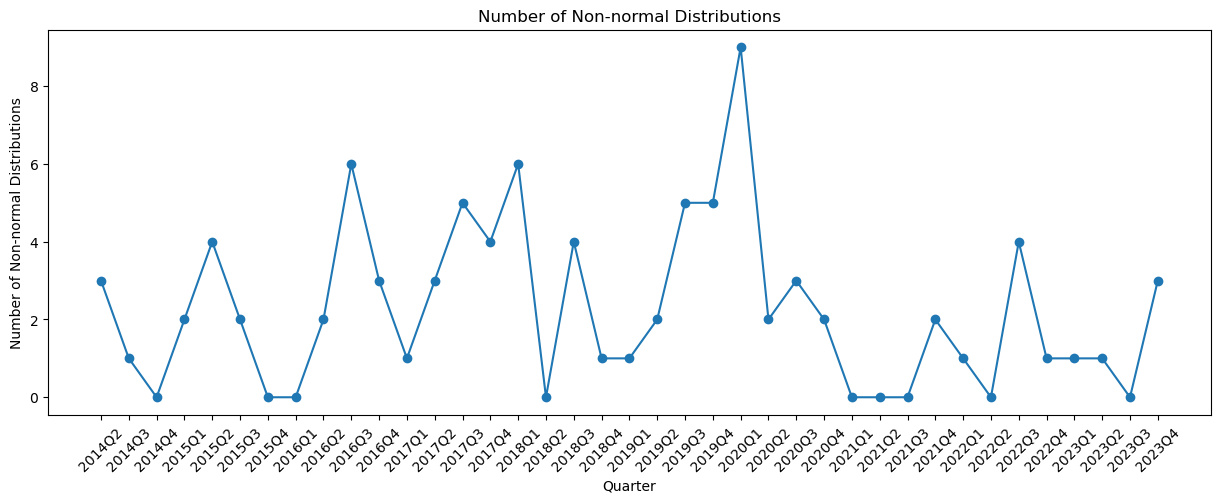

In [37]:
# plot distribution of non_normal
plt.figure(figsize=(15, 5))
plt.plot(str_qt, non_normal, marker='o')
plt.xticks(rotation=45)
plt.title('Number of Non-normal Distributions')
plt.xlabel('Quarter')
plt.ylabel('Number of Non-normal Distributions')

### Cacluate vaue at risk for each group for each quarter

In [211]:
from scipy.stats import norm

In [38]:
entire_var_lst = []
for returns in returns_lst:
    quarter_var_lst = []
    for col in returns.columns:
        # var = norm.ppf(0.05, np.mean(returns[col]), np.std(returns[col])) 
        var = returns[col].quantile(0.05)
        quarter_var_lst.append(var)
    entire_var_lst.append(quarter_var_lst)

In [39]:
# get value at risk for market return
market_return_var_lst = []
for market_return in makt_returns_lst:
    # market_return_var = norm.ppf(0.05, np.mean(market_return), np.std(market_return))
    market_return_var = market_return.quantile(0.05)
    market_return_var_lst.append(market_return_var)

In [126]:
var_df = pd.DataFrame(entire_var_lst).transpose()
var_df.columns = quarter_lst[1:]
var_df.style.apply(lambda x: ["background: lightblue" if v > market_return_var_lst[i] else "" for i, v in enumerate(x)], axis = 1)

,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,-0.014738,-0.010501,-0.016029,-0.014243,-0.010395,-0.026129,-0.014475,-0.029224,-0.011432,-0.007563,-0.011114,-0.006421,-0.007271,-0.005791,-0.006009,-0.019923,-0.011727,-0.007509,-0.025124,-0.008264,-0.010540,-0.009544,-0.006223,-0.069771,-0.027254,-0.019930,-0.015546,-0.018713,-0.007906,-0.012407,-0.012325,-0.021216,-0.036868,-0.021925,-0.022748,-0.016172,-0.010103,-0.013202,-0.013477
1,-0.010808,-0.015227,-0.016895,-0.016423,-0.009624,-0.026819,-0.017758,-0.013957,-0.011770,-0.011274,-0.009218,-0.009294,-0.014816,-0.007384,-0.015159,-0.016551,-0.010011,-0.012789,-0.033522,-0.023648,-0.007358,-0.014232,-0.012938,-0.050223,-0.032111,-0.020734,-0.014710,-0.024159,-0.014905,-0.012329,-0.016358,-0.008900,-0.021723,-0.021446,-0.036482,-0.018084,-0.022775,-0.014005,-0.018970
2,-0.020230,-0.015303,-0.035878,-0.018787,-0.015913,-0.032707,-0.017227,-0.021923,-0.014512,-0.014444,-0.011661,-0.005814,-0.017672,-0.008997,-0.006417,-0.021985,-0.019764,-0.007510,-0.021441,-0.014441,-0.020610,-0.023992,-0.008362,-0.087901,-0.034633,-0.022256,-0.020201,-0.013641,-0.015372,-0.021653,-0.023306,-0.024089,-0.048593,-0.026109,-0.017290,-0.027968,-0.017253,-0.010994,-0.017617
3,-0.016931,-0.011325,-0.015721,-0.021354,-0.022679,-0.024809,-0.023227,-0.041079,-0.015275,-0.010634,-0.011972,-0.006109,-0.008189,-0.010607,-0.007532,-0.028287,-0.014283,-0.014045,-0.038435,-0.023202,-0.015959,-0.026590,-0.019986,-0.056412,-0.037312,-0.019454,-0.011452,-0.023385,-0.011622,-0.015989,-0.026200,-0.034064,-0.032880,-0.020446,-0.021925,-0.015652,-0.016835,-0.018742,-0.013688
4,-0.022408,-0.014697,-0.020669,-0.016573,-0.014251,-0.042364,-0.012544,-0.027730,-0.014948,-0.011518,-0.019616,-0.014521,-0.012463,-0.015259,-0.007557,-0.017414,-0.018825,-0.014204,-0.027465,-0.013717,-0.016266,-0.019748,-0.010935,-0.058275,-0.018327,-0.031674,-0.022110,-0.025520,-0.011731,-0.015627,-0.018487,-0.022109,-0.026552,-0.021472,-0.035436,-0.027745,-0.015890,-0.012684,-0.014149
5,-0.016030,-0.008579,-0.008260,-0.018416,-0.010474,-0.024614,-0.017571,-0.024441,-0.019139,-0.011843,-0.011255,-0.006540,-0.017729,-0.016269,-0.016467,-0.017967,-0.012638,-0.008530,-0.043344,-0.009019,-0.024536,-0.026097,-0.013944,-0.052814,-0.039019,-0.021775,-0.021947,-0.014960,-0.017366,-0.017345,-0.019545,-0.017082,-0.040394,-0.024959,-0.041963,-0.019459,-0.018184,-0.015904,-0.010965
6,-0.010367,-0.009532,-0.017427,-0.016733,-0.013613,-0.024806,-0.018939,-0.019995,-0.015786,-0.013498,-0.012864,-0.012671,-0.009605,-0.009517,-0.009757,-0.025284,-0.019233,-0.009603,-0.024691,-0.014950,-0.015493,-0.013578,-0.013153,-0.056014,-0.033338,-0.015255,-0.015536,-0.013954,-0.020591,-0.013938,-0.024084,-0.026833,-0.043030,-0.050848,-0.025079,-0.021870,-0.014143,-0.010199,-0.020948
7,-0.009798,-0.011226,-0.026867,-0.024190,-0.016613,-0.020234,-0.021764,-0.022983,-0.013827,-0.013969,-0.017758,-0.010874,-0.011610,-0.023953,-0.014840,-0.020321,-0.019414,-0.020737,-0.026591,-0.023578,-0.019553,-0.018181,-0.015024,-0.048498,-0.025060,-0.022236,-0.010452,-0.017094,-0.013069,-0.015166,-0.020152,-0.022948,-0.039749,-0.017759,-0.027580,-0.025206,-0.020026,-0.010903,-0.015798
8,-0.022872,-0.017280,nan,-0.027652,-0.014344,-0.027411,-0.014430,-0.040534,-0.017637,-0.011213,-0.010526,-0.009385,-0.020627,-0.013057,-0.007984,-0.023462,-0.009722,-0.019664,-0.033385,-0.007991,-0.014457,-0.023884,-0.015663,-0.055261,-0.028201,-0.029013,-0.016462,-0.019200,-0.014723,-0.012057,-0.015508,-0.029634,-0.036133,-0.026250,-0.027092,-0.017877,-0.017999,-0.013406,-0.022774
9,-0.018094,-0.010304,nan,-0.025175,-0.023935,-0.039643,-0.017973,nan,-0.011725,-0.019502,-0.013424,-0.011712,-0.014868,-0.022560,-0.025846,-0.036556,-0.012383,-0.033849,-0.023566,nan,-0.031660,-0.017576,

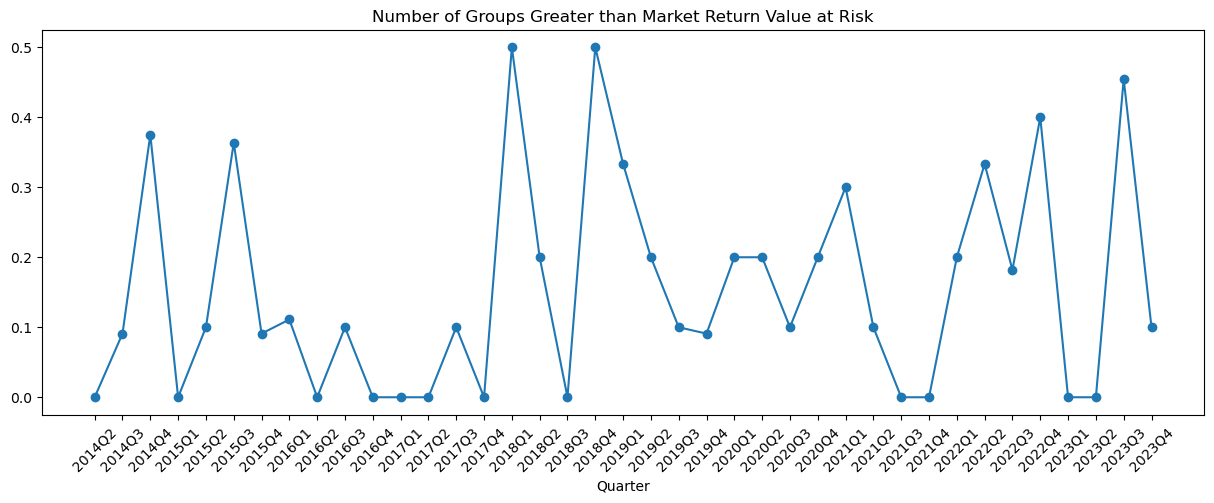

In [42]:
# get the number of elemnts in column[i] of var_df that is greater than market_return_var_lst[i]
num_greater = []
for i in range(var_df.shape[1]):
    num_greater.append(var_df[var_df.columns[i]][var_df[var_df.columns[i]] > market_return_var_lst[i]].count() / var_df[var_df.columns[i]].count())

plt.figure(figsize=(15, 5))
plt.plot(str_qt, num_greater, marker='o')
plt.xticks(rotation=45)
plt.title('Number of Groups Greater than Market Return Value at Risk')
plt.xlabel('Quarter')
plt.show()

### For CVaR calculation

In [43]:
# calculate conditional value at risk
entire_cvar_lst = []
for returns in returns_lst:
    quarter_cvar_lst = []
    for col in returns.columns:
        # var = norm.ppf(0.05, np.mean(returns[col]), np.std(returns[col])) 
        var = returns[col].quantile(0.05)
        cvar = returns[col][returns[col] <= var].mean()
        quarter_cvar_lst.append(cvar)
    entire_cvar_lst.append(quarter_cvar_lst)

In [44]:
# get value at risk for market return
market_return_cvar_lst = []
for market_return in makt_returns_lst:
    # market_return_cvar = norm.ppf(0.05, np.mean(market_return), np.std(market_return)) 
    market_return_cvar = market_return.quantile(0.05)
    mkt_cvar = market_return[market_return <= var].mean()
    market_return_cvar_lst.append(mkt_cvar)

In [45]:
cvar_df = pd.DataFrame(entire_cvar_lst).transpose()
cvar_df.columns = quarter_lst[1:]
cvar_df.style.apply(lambda x: ["background: lightblue" if v > market_return_cvar_lst[i] else "" for i, v in enumerate(x)], axis = 1)

,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,-0.020122,-0.014278,-0.017032,-0.016273,-0.013136,-0.030638,-0.015767,-0.030391,-0.018545,-0.014589,-0.012339,-0.009926,-0.011488,-0.010819,-0.009769,-0.028417,-0.017632,-0.008940,-0.030140,-0.020845,-0.016867,-0.019271,-0.012232,-0.093232,-0.036885,-0.026887,-0.020629,-0.026484,-0.013035,-0.015493,-0.017469,-0.025527,-0.040899,-0.028190,-0.024834,-0.018720,-0.014177,-0.015541,-0.015822
1,-0.011956,-0.017144,-0.020978,-0.024360,-0.015041,-0.031146,-0.020887,-0.021640,-0.020832,-0.014591,-0.012783,-0.011807,-0.018316,-0.012233,-0.021925,-0.025667,-0.014382,-0.024245,-0.038425,-0.027701,-0.012641,-0.026450,-0.016262,-0.082097,-0.050486,-0.028553,-0.026782,-0.029066,-0.021945,-0.018378,-0.020453,-0.013309,-0.028480,-0.039391,-0.041239,-0.018840,-0.029298,-0.017696,-0.022415
2,-0.030694,-0.018921,-0.046892,-0.020849,-0.032560,-0.046191,-0.023368,-0.024352,-0.031395,-0.038096,-0.018211,-0.008278,-0.019219,-0.010947,-0.008986,-0.036280,-0.023328,-0.008174,-0.031430,-0.025262,-0.025487,-0.032020,-0.010329,-0.106213,-0.049878,-0.037623,-0.025197,-0.021302,-0.022501,-0.023261,-0.026504,-0.024807,-0.066045,-0.041839,-0.027399,-0.034061,-0.019862,-0.013960,-0.050009
3,-0.021341,-0.015663,-0.016979,-0.034946,-0.085022,-0.035039,-0.028780,-0.046070,-0.022400,-0.017322,-0.013090,-0.010313,-0.012521,-0.013221,-0.014872,-0.038182,-0.017776,-0.017306,-0.042897,-0.035894,-0.023588,-0.049437,-0.025228,-0.071310,-0.050317,-0.023931,-0.022726,-0.031254,-0.015785,-0.020442,-0.035150,-0.037492,-0.034708,-0.027878,-0.033259,-0.024320,-0.022077,-0.021125,-0.020757
4,-0.030776,-0.018493,-0.028529,-0.017398,-0.037432,-0.064473,-0.020483,-0.035912,-0.016532,-0.018276,-0.024330,-0.019909,-0.014055,-0.023349,-0.008853,-0.029644,-0.020208,-0.019615,-0.039474,-0.023962,-0.026872,-0.024344,-0.014987,-0.086611,-0.025875,-0.037403,-0.030875,-0.030426,-0.015113,-0.019821,-0.022234,-0.029136,-0.035096,-0.027824,-0.049970,-0.029959,-0.019667,-0.015789,-0.017284
5,-0.021266,-0.012533,-0.008972,-0.024674,-0.014717,-0.033020,-0.018557,-0.031254,-0.026823,-0.019296,-0.014636,-0.006806,-0.021105,-0.025263,-0.018532,-0.030330,-0.014318,-0.009983,-0.045843,-0.010896,-0.028017,-0.033789,-0.026921,-0.068631,-0.053550,-0.030043,-0.026273,-0.019381,-0.023713,-0.022389,-0.021821,-0.018763,-0.044894,-0.032669,-0.049580,-0.022024,-0.031461,-0.018326,-0.013553
6,-0.013332,-0.017505,-0.027613,-0.021165,-0.016410,-0.030789,-0.023036,-0.025767,-0.027699,-0.018453,-0.014336,-0.019131,-0.015769,-0.012314,-0.012665,-0.038111,-0.026910,-0.014302,-0.027650,-0.023280,-0.019922,-0.023038,-0.061387,-0.071878,-0.038678,-0.020577,-0.021410,-0.017336,-0.025085,-0.022245,-0.025737,-0.028031,-0.048455,-0.139563,-0.027699,-0.023339,-0.024120,-0.013600,-0.022600
7,-0.013500,-0.013359,-0.031230,-0.030148,-0.018092,-0.027666,-0.024861,-0.030955,-0.015967,-0.018934,-0.021577,-0.015664,-0.015293,-0.034808,-0.020826,-0.030176,-0.025551,-0.035951,-0.032081,-0.027252,-0.023347,-0.022690,-0.022903,-0.078235,-0.029151,-0.029135,-0.018127,-0.019706,-0.021564,-0.017504,-0.033518,-0.037066,-0.044723,-0.026401,-0.032232,-0.031866,-0.020690,-0.014027,-0.017242
8,-0.035485,-0.019480,nan,-0.036630,-0.022855,-0.028715,-0.017319,-0.048127,-0.019228,-0.019510,-0.013085,-0.011391,-0.024577,-0.020475,-0.010695,-0.028182,-0.015330,-0.020372,-0.045977,-0.009589,-0.020455,-0.030121,-0.019190,-0.097594,-0.033903,-0.056467,-0.024386,-0.022579,-0.020309,-0.018347,-0.022941,-0.036469,-0.042842,-0.035846,-0.029027,-0.023813,-0.024019,-0.020751,-0.027033
9,-0.028569,-0.012216,nan,-0.030806,-0.028943,-0.054704,-0.024258,nan,-0.020820,-0.035895,-0.018862,-0.022396,-0.015768,-0.035370,-0.031117,-0.063117,-0.016268,-0.042362,-0.032852,nan,-0.042340,-0.025654,

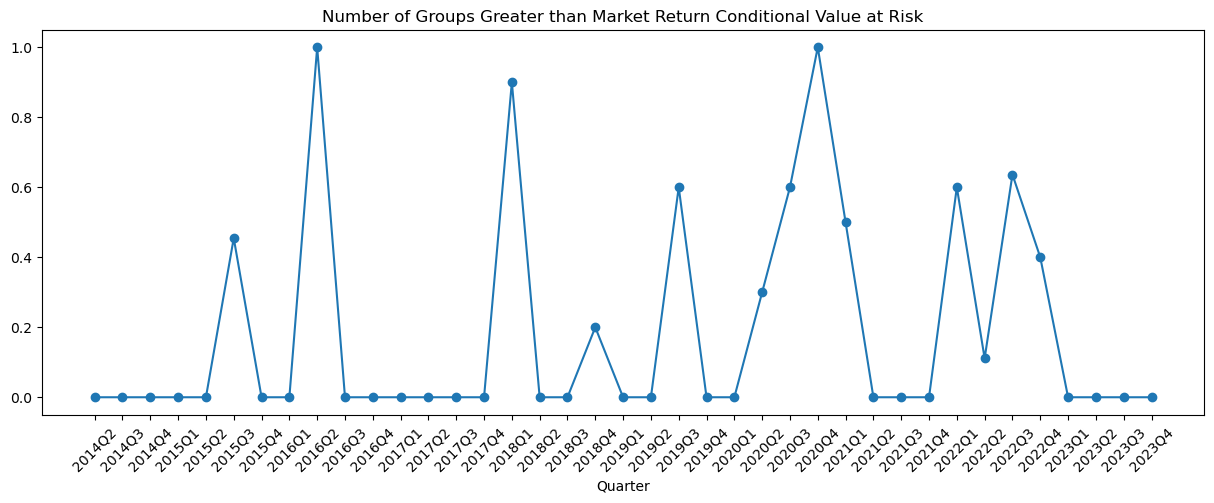

In [46]:
# get the number of elemnts in column[i] of var_df that is greater than market_return_var_lst[i]
num_greater = []
for i in range(cvar_df.shape[1]):
    num_greater.append(cvar_df[cvar_df.columns[i]][cvar_df[cvar_df.columns[i]] > market_return_cvar_lst[i]].count() / cvar_df[cvar_df.columns[i]].count())

plt.figure(figsize=(15, 5))
plt.plot(str_qt, num_greater, marker='o')
plt.xticks(rotation=45)
plt.title('Number of Groups Greater than Market Return Conditional Value at Risk')
plt.xlabel('Quarter')
plt.show()

### PLotting Sharpe ratio and information ratio larger than threshold

In [47]:
i_r_df = pd.DataFrame(info_ratio_lst).transpose()
i_r_df.columns = quarter_lst[1:]
# highlight cells with value larger than 0.03
i_r_df.style.apply(lambda x: ['background-color : yellow' if v > 0.03 else "" for v in x], axis=1)

,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,-0.109036,-0.043226,0.265638,0.229478,-0.086159,0.028778,-0.117175,0.100534,0.085406,0.030432,0.077165,0.023625,0.285591,-0.012737,-0.086843,-0.098229,0.057218,0.059015,0.028680,0.348602,0.026063,0.097307,-0.115490,-0.086680,0.212124,-0.034321,0.022891,0.002983,-0.028571,0.027207,-0.111353,-0.101025,-0.128337,0.066028,0.164400,-0.044794,-0.137938,-0.038420,0.073725
1,0.033372,0.141719,-0.004641,-0.023141,0.125993,-0.052665,-0.103895,0.114879,0.151117,0.108522,-0.274979,-0.171312,0.198961,0.059789,0.097368,-0.023626,-0.138995,-0.112309,-0.096546,-0.040130,0.121379,-0.034492,0.154773,0.180342,-0.064071,-0.049865,0.047389,-0.000696,0.046139,-0.004383,-0.134811,0.187400,0.128245,-0.116093,0.050687,-0.178664,-0.180675,-0.075573,0.162164
2,0.125868,-0.193582,-0.166112,-0.088657,-0.160407,-0.120906,-0.014812,0.111477,-0.021741,-0.039455,0.238976,0.316432,-0.153113,-0.106922,-0.037050,0.331506,-0.113556,-0.132054,0.105052,-0.088132,-0.099695,-0.018165,0.305893,-0.115847,0.113971,0.137168,0.096878,-0.045428,-0.060752,-0.112737,-0.002333,0.023282,0.065202,-0.233885,0.011507,-0.264805,-0.120995,-0.075544,-0.096290
3,0.258420,-0.198959,0.154954,-0.140779,0.051221,-0.052008,-0.050914,0.018735,-0.028861,0.176612,0.159135,0.031364,0.108873,-0.141507,-0.019092,0.050955,0.093757,0.149464,-0.238476,-0.166818,0.085440,-0.104066,0.034497,0.223651,-0.070782,-0.107659,0.065760,-0.192484,-0.023960,-0.005937,-0.143971,-0.089580,-0.036387,0.077538,-0.003885,-0.078493,-0.121914,-0.021247,-0.012701
4,-0.016870,0.210329,0.070445,0.315752,-0.103930,-0.067852,-0.025342,-0.268777,-0.054203,0.051642,-0.098225,0.104034,-0.045520,-0.018548,-0.044605,0.137658,0.072913,-0.037065,0.085978,0.254112,-0.006855,-0.044179,-0.147705,-0.067417,0.041783,-0.056850,0.067704,0.184096,0.077932,0.057110,-0.072099,0.052461,0.143435,0.074098,0.285100,0.098936,-0.166355,0.143665,0.019605
5,-0.193093,0.059068,0.248823,0.160072,-0.082174,-0.137405,0.126374,0.039363,0.031095,-0.128988,-0.225930,0.065703,0.136431,0.075090,-0.324535,0.156298,-0.001336,0.013973,-0.075502,-0.005454,-0.004602,-0.119698,-0.280589,0.136284,0.056277,-0.146852,-0.021471,0.055933,-0.106867,0.042984,-0.036261,0.119572,-0.005707,0.174006,-0.062901,0.061681,-0.229331,0.060472,0.080967
6,-0.077873,-0.084316,-0.048732,0.074175,-0.283923,0.014102,0.014629,0.029553,0.092252,-0.247034,0.032763,0.139428,-0.152973,-0.164055,0.091251,0.107889,-0.039788,-0.094725,0.009516,0.006016,-0.032689,0.012154,-0.114464,0.058201,0.041117,0.028245,-0.103310,0.048427,0.010959,-0.035661,-0.085758,0.177414,-0.125759,-0.084379,-0.007036,-0.160083,-0.168114,0.228861,0.153829
7,-0.060172,0.195227,0.075934,0.039446,-0.094677,0.221800,0.011030,-0.051983,-0.021908,-0.231829,0.163542,0.097137,-0.086240,-0.070650,0.076348,-0.037037,0.178367,0.034270,-0.004655,-0.079561,-0.050779,0.117993,-0.095599,0.103807,0.021904,-0.153937,0.121018,0.112875,0.239907,0.059844,-0.093820,-0.154089,0.029348,-0.036846,-0.070796,-0.150408,-0.075670,0.196980,-0.021667
8,-0.122987,-0.039886,nan,0.135808,-0.205806,-0.164139,0.097540,-0.103739,-0.040673,0.062579,-0.018320,-0.073047,0.104081,0.120153,-0.010660,-0.063934,0.014601,-0.003825,0.000547,0.048067,-0.072128,-0.016664,0.036405,-0.073367,-0.037001,-0.055236,0.150828,0.007646,0.063344,0.013775,0.160195,-0.060485,0.010196,-0.002630,-0.085965,-0.002196,0.058174,0.055948,-0.024561
9,-0.106692,0.272521,nan,0.064375,-0.156501,-0.092335,0.049262,nan,0.179200,0.145118,0.015074,0.046650,0.214643,0.144447,-0.168148,-0.093150,-0.074737,-0.033920,0.195464,nan,-0.089776,-0.037176,-0.122404,0.348008,0.187439,0.084618,-0.043124,-0.025943,0.065567,-0.234858,-0.165845,-0.098681,nan,-0.071966,0.113054,0.155983,-0.202740,-0.116664,-0.106633


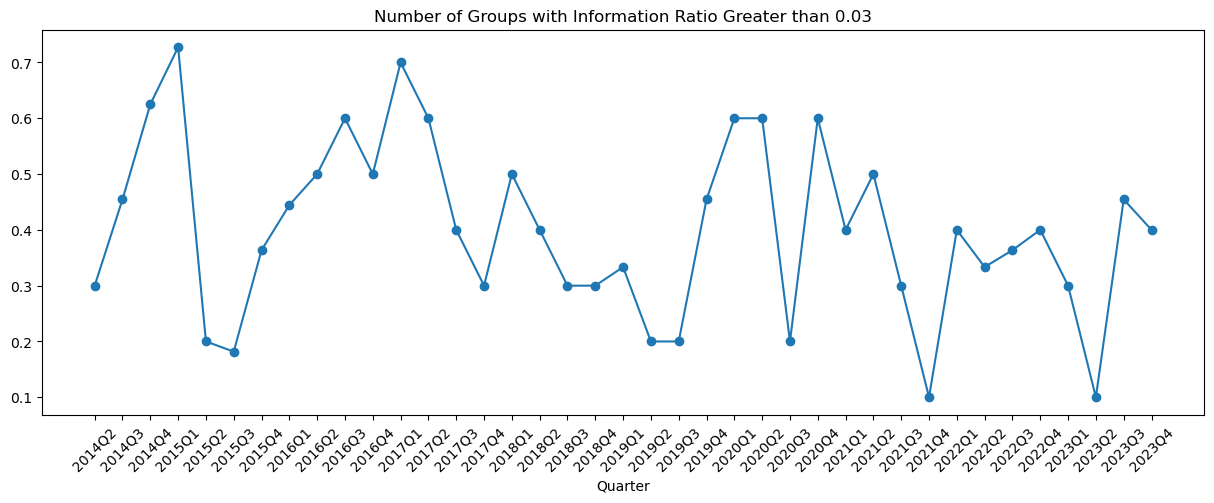

In [48]:
# get the number of elemnts in column[i] of var_df that is greater than market_return_var_lst[i]
num_greater = []
for i in range(i_r_df.shape[1]):
    num_greater.append(i_r_df[i_r_df.columns[i]][i_r_df[i_r_df.columns[i]] > 0.03].count() / i_r_df[i_r_df.columns[i]].count())

plt.figure(figsize=(15, 5))
plt.plot(str_qt, num_greater, marker='o')
plt.xticks(rotation=45)
plt.title('Number of Groups with Information Ratio Greater than 0.03')
plt.xlabel('Quarter')
plt.show()

In [110]:
s_r_df = pd.DataFrame(sharpe_ratio_lst).transpose()
# rename columns of s_r_df to quarter_lst
s_r_df.columns = quarter_lst[1:]
# color the cells with values above market_sharpe_ratio_lst
s_r_df.style.apply(lambda x: ["background: lightgreen" if v > market_sharpe_ratio_lst[i] else "" for i, v in enumerate(x)], axis = 1)

,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,0.000339,-0.036914,0.166166,0.048389,-0.036970,-0.106084,-0.023094,-0.096001,-0.194259,-0.332091,-0.479406,-0.926463,-1.483258,-2.054740,-2.327307,-1.586473,-2.109616,-3.621807,-1.674517,-2.353486,-2.818810,-2.495323,-2.452471,-0.385898,0.159129,-0.002350,0.084330,0.073698,0.133409,-0.051632,0.094913,-0.279053,-0.723613,-2.097011,-2.594208,-4.209783,-6.478603,-7.549594,-5.876663
1,0.088178,0.072127,0.086694,-0.015228,0.063372,-0.112607,-0.058275,-0.133295,-0.201955,-0.293236,-0.648197,-1.041524,-0.825570,-1.742085,-0.762450,-1.562598,-2.680110,-2.091614,-1.291443,-1.724035,-3.131523,-1.745480,-1.462419,-0.349941,0.081220,0.000693,0.085188,0.048092,0.115561,-0.054395,0.027134,-0.140096,-0.926659,-1.779714,-1.591760,-4.047137,-3.519813,-7.391320,-3.592575
2,0.127360,-0.156029,-0.077013,-0.049813,-0.143193,-0.150915,0.000433,-0.161021,-0.172419,-0.195871,-0.155698,-0.807803,-0.964033,-1.980948,-2.077969,-1.095649,-1.715546,-3.717268,-1.871506,-2.104283,-1.829577,-1.485873,-1.394665,-0.344522,0.161946,0.096100,0.121379,0.038740,0.032257,-0.116028,0.069808,-0.241675,-0.416562,-1.808680,-2.633891,-3.119112,-4.309800,-8.089134,-2.659368
3,0.248490,-0.106184,0.217730,-0.114726,0.048817,-0.120418,-0.034810,-0.085275,-0.216672,-0.197388,-0.266996,-0.887036,-1.116065,-1.913391,-1.611843,-1.077290,-1.786220,-1.682352,-1.307921,-1.592832,-2.158990,-1.157267,-1.180658,-0.326649,0.065065,-0.059620,0.116160,-0.040973,0.101386,-0.041953,-0.039164,-0.207252,-0.733652,-1.900222,-2.077343,-3.802002,-4.682190,-4.934583,-4.037346
4,0.017526,0.135068,0.110427,0.281513,-0.090630,-0.108678,-0.010343,-0.309707,-0.313654,-0.252392,-0.280166,-0.399662,-0.931143,-1.049893,-2.297703,-1.379907,-1.553181,-2.357145,-1.558151,-1.668812,-1.999515,-1.836890,-1.784460,-0.417455,0.173915,-0.037696,0.098595,0.204640,0.182819,-0.013104,0.053060,-0.222354,-0.666544,-1.583791,-1.336612,-2.198928,-5.401396,-6.592157,-3.788314
5,-0.065919,0.006543,0.353861,0.149092,-0.058507,-0.192838,0.076260,-0.127334,-0.158631,-0.383435,-0.693856,-1.000119,-0.943638,-0.576805,-1.840926,-0.815194,-2.240175,-3.262468,-1.202968,-2.827316,-1.676984,-1.562017,-1.697350,-0.365712,0.112769,-0.068297,0.042816,0.114865,0.009667,-0.011623,0.069163,-0.264908,-0.673213,-1.501791,-1.544928,-3.745636,-3.778884,-6.123535,-6.404311
6,0.015957,-0.091424,0.031677,0.048622,-0.150984,-0.104813,0.015570,-0.172879,-0.108327,-0.514000,-0.420256,-0.336377,-1.412318,-1.782901,-1.264064,-1.134442,-1.251079,-2.872445,-1.769348,-1.815432,-2.504037,-2.100590,-0.733185,-0.397476,0.136096,0.043639,0.024184,0.116995,0.082676,-0.078214,0.014709,-0.086554,-0.762297,-0.560289,-2.428144,-3.818999,-5.839943,-7.309540,-3.497141
7,0.041246,0.104170,0.121989,0.029596,-0.072690,0.022974,0.014912,-0.192650,-0.281080,-0.477020,-0.079056,-0.524655,-1.309209,-0.652012,-0.858622,-1.290473,-1.123077,-1.198702,-1.724559,-1.486107,-2.009338,-2.113991,-1.489172,-0.365817,0.170376,-0.112502,0.164684,0.148432,0.292250,0.007560,0.009348,-0.306770,-0.569738,-2.203652,-2.166991,-3.051491,-3.810260,-6.593039,-4.837581
8,-0.068830,-0.054755,nan,0.120108,-0.154953,-0.171461,0.070034,-0.190929,-0.257570,-0.210226,-0.486960,-0.841684,-0.764734,-0.797457,-1.473818,-1.317669,-2.158154,-1.661613,-1.117684,-3.279386,-2.709674,-1.787180,-1.069784,-0.419022,0.107732,-0.038810,0.145166,0.082247,0.144108,-0.042676,0.204252,-0.255899,-0.700570,-1.503289,-2.372605,-3.673345,-3.277222,-5.876975,-3.506988
9,-0.064481,0.157447,nan,0.052308,-0.118457,-0.124287,0.049603,nan,-0.074774,0.001734,-0.255132,-0.502361,-0.309921,-0.282773,-0.957035,-0.784536,-2.445226,-0.994672,-1.440361,nan,-1.241519,-1.673293,-1.371904,-0.230918,0.196951,0.081952,0.033402,0.015675,0.170323,-0.213650,-0.12912

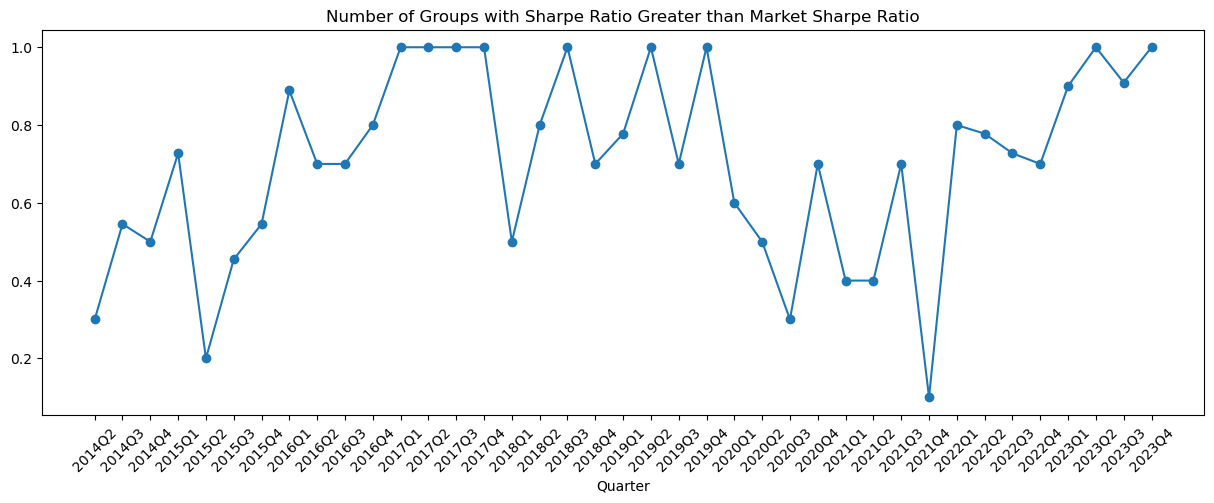

In [50]:
# get the number of elemnts in column[i] of var_df that is greater than market_return_var_lst[i]
num_greater = []
for i in range(s_r_df.shape[1]):
    num_greater.append(s_r_df[s_r_df.columns[i]][s_r_df[s_r_df.columns[i]] > market_sharpe_ratio_lst[i]].count() / s_r_df[s_r_df.columns[i]].count())

plt.figure(figsize=(15, 5))
plt.plot(str_qt, num_greater, marker='o')
plt.xticks(rotation=45)
plt.title('Number of Groups with Sharpe Ratio Greater than Market Sharpe Ratio')
plt.xlabel('Quarter')
plt.show()

### Correlation within groups

In [13]:
group_corr = []
for i, groups in enumerate(same_topic_tic_lst):
    # get correlation between the groups
    group_corr.append(stock_price[groups].corr())

for group in group_corr:
    group = group.dropna(how='all').dropna(axis=1, how='all')
    sns.heatmap(group, cmap='coolwarm', vmin=-1, vmax=1)
    plt.show()

# Step 5: Get the GICS sector funds and do the same analysis for above

In [53]:
sector_qt_lst = []
sector_funds = ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'SMH', 'XTL', 'XLU', 'IYR']
for qt in tqdm(quarter_lst[1:]):
    end = datetime.datetime.strptime(qt.strftime('%Y-%m-%d'), '%Y-%m-%d') + pd.DateOffset(days=1)
    start = (end - pd.DateOffset(months=3)).replace(day=1)
    sector_df = pd.DataFrame()
    for sector in sector_funds:
        sector_return = yf.download(sector, start=start, end=end, progress=False)['Close']
        sector_return = sector_return.rename(sector)
        sector_df = pd.concat([sector_df, sector_return], axis=1)
    sector_qt_lst.append(sector_df)

100%|██████████| 39/39 [01:06<00:00,  1.70s/it]


In [63]:
gics_returns_lst = []
gics_sharpe_ratio_lst = []
gics_info_ratio_lst = []
for i, group_price in tqdm(enumerate(sector_qt_lst), total=len(sector_qt_lst)):
    gics_returns_lst.append(group_price.pct_change())
    end_date = datetime.datetime.strptime(quarter_lst[i+1].strftime('%Y-%m-%d'), '%Y-%m-%d') + pd.DateOffset(days=1)
    start_date = (end_date - pd.DateOffset(months=3)).replace(day=1)

    market_return, risk_free_rate = get_mktrf_rf(start_date, end_date + pd.DateOffset(days=1))
    sharpe_ratio_per_group = get_sharpe_ratio(group_price, risk_free_rate)
    info_ratio_per_group = get_info_ratio(group_price, market_return)

    gics_sharpe_ratio_lst.append(sharpe_ratio_per_group)
    gics_info_ratio_lst.append(info_ratio_per_group)

100%|██████████| 39/39 [00:07<00:00,  5.04it/s]


In [65]:
gics_entire_var_lst = []
for returns in gics_returns_lst:
    quarter_var_lst = []
    for col in returns.columns:
        # var = norm.ppf(0.05, np.mean(returns[col]), np.std(returns[col])) 
        var = returns[col].quantile(0.05)
        quarter_var_lst.append(var)
    gics_entire_var_lst.append(quarter_var_lst)

gics_var_df = pd.DataFrame(gics_entire_var_lst).transpose()
gics_var_df.columns = quarter_lst[1:]
gics_var_df.style.apply(lambda x: ["background: lightblue" if v > market_return_var_lst[i] else "" for i, v in enumerate(x)], axis = 1)

,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,-0.013772,-0.015528,-0.030874,-0.019061,-0.015739,-0.034798,-0.026155,-0.034374,-0.020960,-0.020096,-0.012230,-0.014495,-0.018006,-0.011084,-0.010079,-0.023346,-0.018472,-0.013818,-0.032688,-0.018887,-0.017514,-0.021982,-0.020033,-0.124740,-0.049111,-0.039016,-0.034744,-0.033225,-0.026436,-0.029644,-0.027643,-0.024762,-0.052193,-0.033374,-0.027377,-0.022799,-0.018880,-0.019877,-0.019403
1,-0.012687,-0.010191,-0.022490,-0.015592,-0.011779,-0.026289,-0.019868,-0.026224,-0.015190,-0.011460,-0.013494,-0.008826,-0.010526,-0.007862,-0.008178,-0.026434,-0.017112,-0.013924,-0.026198,-0.013890,-0.015230,-0.016321,-0.011093,-0.063936,-0.028952,-0.021708,-0.016832,-0.019516,-0.016840,-0.015506,-0.014134,-0.017438,-0.031586,-0.020433,-0.024593,-0.019705,-0.015469,-0.016192,-0.014856
2,-0.013229,-0.012388,-0.017832,-0.016264,-0.011147,-0.025937,-0.015780,-0.019559,-0.012264,-0.010118,-0.009979,-0.008758,-0.008462,-0.009374,-0.008411,-0.020748,-0.015831,-0.009859,-0.030468,-0.010117,-0.015146,-0.021184,-0.010886,-0.073668,-0.029204,-0.019112,-0.012897,-0.017526,-0.014479,-0.014580,-0.016761,-0.016377,-0.029487,-0.018994,-0.019072,-0.019153,-0.013647,-0.012730,-0.010274
3,-0.016467,-0.010990,-0.014708,-0.013135,-0.010371,-0.027812,-0.016319,-0.020535,-0.011834,-0.010804,-0.010649,-0.005071,-0.008554,-0.009145,-0.006457,-0.021166,-0.012671,-0.008338,-0.029933,-0.014635,-0.012369,-0.014712,-0.009866,-0.057448,-0.023367,-0.015619,-0.017994,-0.023541,-0.011851,-0.018999,-0.019353,-0.029322,-0.050596,-0.031755,-0.030458,-0.022279,-0.015401,-0.018204,-0.020120
4,-0.007067,-0.008819,-0.011813,-0.011747,-0.008935,-0.017751,-0.011524,-0.012829,-0.012511,-0.009735,-0.010768,-0.005506,-0.008048,-0.009095,-0.009598,-0.019229,-0.015899,-0.007566,-0.019337,-0.009159,-0.012227,-0.015282,-0.007915,-0.049050,-0.019604,-0.013382,-0.012982,-0.012797,-0.011087,-0.012404,-0.007802,-0.014410,-0.018945,-0.017255,-0.014943,-0.009765,-0.008449,-0.009933,-0.013566
5,-0.009970,-0.010834,-0.015860,-0.015718,-0.012567,-0.027232,-0.017276,-0.019528,-0.013374,-0.013192,-0.014249,-0.007861,-0.008936,-0.007857,-0.009836,-0.021419,-0.012722,-0.006041,-0.025425,-0.013609,-0.018559,-0.011048,-0.007073,-0.051982,-0.020125,-0.014882,-0.013990,-0.012117,-0.009322,-0.013745,-0.009667,-0.016083,-0.025813,-0.016365,-0.014514,-0.014093,-0.010262,-0.008738,-0.009879
6,-0.012036,-0.010264,-0.016409,-0.016344,-0.011147,-0.024029,-0.015030,-0.026095,-0.014730,-0.014875,-0.010879,-0.013317,-0.009668,-0.016754,-0.007082,-0.030696,-0.012318,-0.011098,-0.026020,-0.012633,-0.013933,-0.022303,-0.006368,-0.084883,-0.037393,-0.021084,-0.019111,-0.018229,-0.017559,-0.016442,-0.021493,-0.022948,-0.029775,-0.020666,-0.017153,-0.026650,-0.012829,-0.012520,-0.015784
7,-0.014128,-0.018634,-0.016050,-0.020392,-0.017736,-0.025305,-0.018746,-0.029433,-0.024035,-0.011581,-0.016357,-0.011747,-0.022158,-0.013254,-0.015502,-0.032539,-0.023340,-0.017478,-0.043753,-0.021873,-0.022777,-0.029289,-0.014501,-0.083099,-0.036603,-0.022222,-0.029116,-0.048558,-0.025421,-0.020742,-0.026034,-0.044352,-0.047778,-0.034517,-0.037971,-0.023947,-0.017774,-0.025817,-0.022115
8,-0.016961,-0.017929,-0.014242,-0.016950,-0.016394,-0.020620,-0.015765,-0.031621,-0.016961,-0.012116,-0.012668,-0.012327,-0.018171,-0.012782,-0.013793,-0.019070,-0.013520,-0.012301,-0.032252,-0.014854,-0.019894,-0.024769,-0.013133,-0.070956,-0.030225,-0.020296,-0.013935,-0.026274,-0.016859,-0.014718,-0.017411,-0.024910,-0.032517,-0.024187,-0.025521,-0.020287,-0.018528,-0.020055,-0.017930
9,-0.014416,-0.015451,-0.016905,-0.021676,-0.013557,-0.016050,-0.017990,-0.013982,-0.018547,-0.015289,-0.020897,-0.010987,-0.007973,-0.009323,-0.011847,-0.014919,-0.012772,-0.012113,-0.018195,-0.011

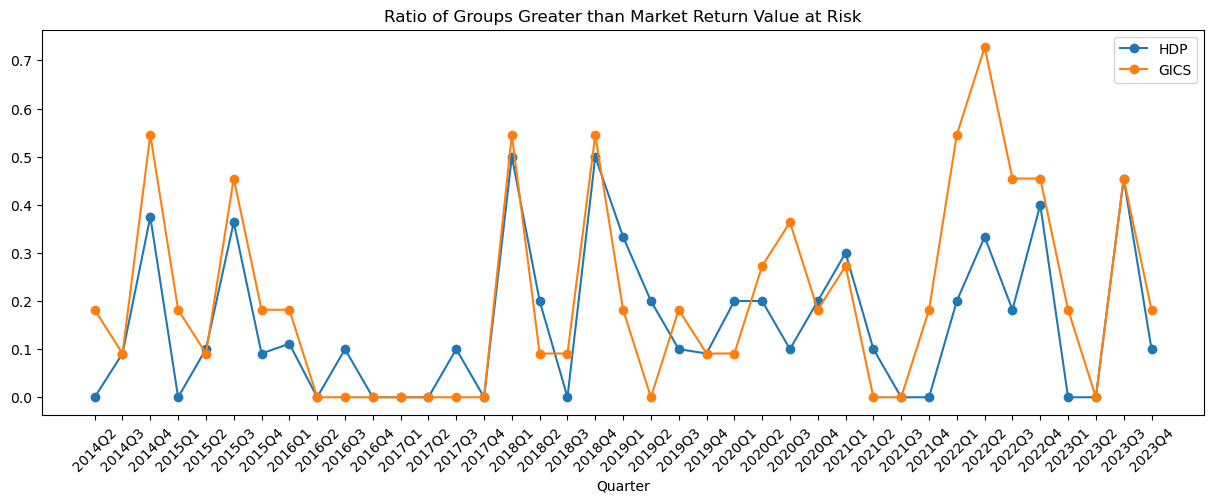

In [66]:
# get the number of elemnts in column[i] of var_df that is greater than market_return_var_lst[i]
num_greater_hdp = []
num_greater_gics = []
for i in range(var_df.shape[1]):
    num_greater_hdp.append(var_df[var_df.columns[i]][var_df[var_df.columns[i]] > market_return_var_lst[i]].count() / var_df[var_df.columns[i]].count())
    num_greater_gics.append(gics_var_df[gics_var_df.columns[i]][gics_var_df[gics_var_df.columns[i]] > market_return_var_lst[i]].count() / gics_var_df[gics_var_df.columns[i]].count())

# plot for both hdp and gics
plt.figure(figsize=(15, 5))
plt.plot(str_qt, num_greater_hdp, marker='o', label='HDP')
plt.plot(str_qt, num_greater_gics, marker='o', label='GICS')
plt.xticks(rotation=45)
plt.title('Ratio of Groups Greater than Market Return Value at Risk')
plt.xlabel('Quarter')
plt.legend()
plt.show()

In [67]:
# calculate conditional value at risk
gics_entire_cvar_lst = []
for returns in gics_returns_lst:
    quarter_cvar_lst = []
    for col in returns.columns:
        # var = norm.ppf(0.05, np.mean(returns[col]), np.std(returns[col])) 
        var = returns[col].quantile(0.05)
        cvar = returns[col][returns[col] <= var].mean()
        quarter_cvar_lst.append(cvar)
    gics_entire_cvar_lst.append(quarter_cvar_lst)

gics_cvar_df = pd.DataFrame(gics_entire_cvar_lst).transpose()
gics_cvar_df.columns = quarter_lst[1:]
gics_cvar_df.style.apply(lambda x: ["background: lightblue" if v > market_return_cvar_lst[i] else "" for i, v in enumerate(x)], axis = 1)

,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,-0.016493,-0.018781,-0.043081,-0.036519,-0.017354,-0.040951,-0.033173,-0.042377,-0.027394,-0.027852,-0.016109,-0.018502,-0.018227,-0.014880,-0.012653,-0.037992,-0.023160,-0.022109,-0.036635,-0.023645,-0.022143,-0.031287,-0.024354,-0.151448,-0.063876,-0.045669,-0.041995,-0.039215,-0.030974,-0.034960,-0.033945,-0.030469,-0.061479,-0.044904,-0.035821,-0.033755,-0.029466,-0.022463,-0.024266
1,-0.015332,-0.014262,-0.025171,-0.020259,-0.015085,-0.032486,-0.021881,-0.028484,-0.027273,-0.019330,-0.014892,-0.011618,-0.014004,-0.011474,-0.009219,-0.034403,-0.021738,-0.015293,-0.030173,-0.024378,-0.018354,-0.022769,-0.014778,-0.090973,-0.045525,-0.029291,-0.022838,-0.024462,-0.020391,-0.020272,-0.019769,-0.024879,-0.036031,-0.027154,-0.028737,-0.024783,-0.017996,-0.019883,-0.018880
2,-0.015217,-0.015989,-0.021155,-0.019596,-0.013889,-0.029253,-0.017648,-0.023765,-0.022291,-0.016726,-0.010946,-0.011046,-0.013244,-0.012372,-0.010809,-0.038993,-0.023177,-0.014231,-0.034824,-0.024577,-0.021004,-0.026597,-0.015413,-0.095703,-0.041118,-0.026459,-0.023159,-0.019962,-0.017184,-0.018345,-0.022299,-0.019967,-0.032532,-0.028049,-0.021216,-0.021813,-0.018344,-0.015300,-0.015864
3,-0.019498,-0.014552,-0.018300,-0.016983,-0.014752,-0.032208,-0.021330,-0.028851,-0.021888,-0.016079,-0.011353,-0.007984,-0.011746,-0.012580,-0.006861,-0.031618,-0.017942,-0.010925,-0.032682,-0.018823,-0.017594,-0.024864,-0.012386,-0.087041,-0.034791,-0.020092,-0.022788,-0.030831,-0.019031,-0.021962,-0.023638,-0.035588,-0.055710,-0.039095,-0.035026,-0.027583,-0.017800,-0.024788,-0.023387
4,-0.008912,-0.012420,-0.012705,-0.017259,-0.012013,-0.025128,-0.015709,-0.016024,-0.017313,-0.016029,-0.016804,-0.007325,-0.011353,-0.010506,-0.010225,-0.026835,-0.020332,-0.009845,-0.024019,-0.010951,-0.014276,-0.019678,-0.011848,-0.068900,-0.024808,-0.016699,-0.018733,-0.017895,-0.013882,-0.014891,-0.015834,-0.019205,-0.033009,-0.023202,-0.016839,-0.014250,-0.012408,-0.011651,-0.016862
5,-0.017509,-0.015204,-0.020806,-0.018405,-0.017307,-0.034791,-0.020349,-0.024420,-0.018106,-0.016670,-0.019028,-0.009173,-0.010555,-0.011430,-0.010770,-0.035926,-0.016514,-0.007299,-0.029800,-0.017710,-0.021815,-0.021388,-0.013280,-0.070441,-0.033075,-0.020341,-0.020065,-0.018821,-0.012019,-0.015125,-0.013977,-0.017973,-0.029614,-0.024656,-0.017764,-0.015511,-0.011525,-0.010665,-0.015490
6,-0.016173,-0.015126,-0.019128,-0.020196,-0.017459,-0.033792,-0.021576,-0.028817,-0.028913,-0.016853,-0.012511,-0.020157,-0.016092,-0.018414,-0.010237,-0.043772,-0.021222,-0.012461,-0.032574,-0.023572,-0.018704,-0.029611,-0.015148,-0.109340,-0.051337,-0.024893,-0.022024,-0.022850,-0.022529,-0.022985,-0.025807,-0.030300,-0.032539,-0.027484,-0.021319,-0.034731,-0.016428,-0.015219,-0.017238
7,-0.025169,-0.020771,-0.031289,-0.030417,-0.023686,-0.028816,-0.022541,-0.038919,-0.034703,-0.019254,-0.025836,-0.015351,-0.031634,-0.021126,-0.024647,-0.039789,-0.033520,-0.023612,-0.051363,-0.039197,-0.033454,-0.036665,-0.018631,-0.103993,-0.047588,-0.036575,-0.031037,-0.053180,-0.034992,-0.028248,-0.032513,-0.047564,-0.053313,-0.047957,-0.045447,-0.026489,-0.024408,-0.032044,-0.028459
8,-0.022020,-0.020540,-0.022360,-0.020046,-0.019226,-0.024778,-0.017355,-0.038374,-0.028843,-0.015667,-0.014536,-0.014951,-0.023589,-0.015350,-0.018685,-0.028549,-0.014642,-0.014715,-0.034424,-0.021655,-0.024585,-0.027909,-0.015083,-0.079105,-0.040851,-0.032636,-0.020142,-0.029058,-0.021623,-0.022330,-0.022047,-0.026429,-0.041193,-0.028973,-0.029981,-0.025337,-0.021795,-0.024789,-0.019558
9,-0.016284,-0.017482,-0.018330,-0.031068,-0.017314,-0.027832,-0.024439,-0.022562,-0.020839,-0.023020,-0.028321,-0.013944,-0.009285,-0.012424,-0.014955,-0.016017,-0.019319,-0.019617,-0.027687,-0.016

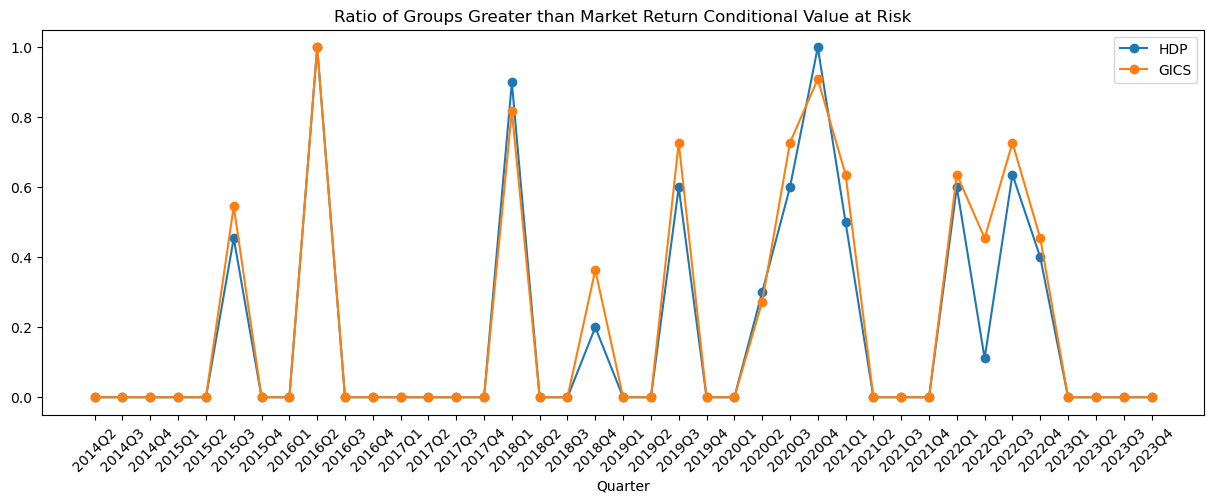

In [68]:
# get the number of elemnts in column[i] of var_df that is greater than market_return_var_lst[i]
num_greater_hdp = []
num_greater_gics = []
for i in range(cvar_df.shape[1]):
    num_greater_hdp.append(cvar_df[cvar_df.columns[i]][cvar_df[cvar_df.columns[i]] > market_return_cvar_lst[i]].count() / cvar_df[cvar_df.columns[i]].count())
    num_greater_gics.append(gics_cvar_df[gics_cvar_df.columns[i]][gics_cvar_df[gics_cvar_df.columns[i]] > market_return_cvar_lst[i]].count() / gics_cvar_df[gics_cvar_df.columns[i]].count())

# plot for both hdp and gics
plt.figure(figsize=(15, 5))
plt.plot(str_qt, num_greater_hdp, marker='o', label='HDP')
plt.plot(str_qt, num_greater_gics, marker='o', label='GICS')
plt.xticks(rotation=45)
plt.title('Ratio of Groups Greater than Market Return Conditional Value at Risk')
plt.xlabel('Quarter')
plt.legend()
plt.show()

In [69]:
gics_i_r_df = pd.DataFrame(gics_info_ratio_lst).transpose()
gics_i_r_df.columns = quarter_lst[1:]
# highlight cells with value larger than 0.03
gics_i_r_df.style.apply(lambda x: ['background-color : yellow' if v > 0.03 else "" for v in x], axis=1)

,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,0.228543,-0.273624,-0.187986,-0.037549,-0.069635,-0.154703,-0.080785,0.015700,0.175827,0.004100,0.054503,-0.301903,-0.176122,-0.002516,-0.000733,-0.121361,0.141099,-0.105479,-0.210773,0.006965,-0.132494,-0.132892,-0.087123,-0.254421,0.075112,-0.233868,0.107344,0.162490,0.008825,-0.037274,-0.066887,0.246052,0.087355,0.051528,0.107384,-0.090827,-0.176971,0.208095,-0.197365
1,0.024401,-0.013111,-0.126166,-0.003491,-0.055483,-0.307295,0.026296,0.051221,0.032753,0.000120,0.021887,0.009760,0.014559,0.039483,-0.008128,-0.156288,-0.024928,-0.167194,0.015584,-0.077408,0.031943,-0.044482,-0.060131,-0.115059,0.075800,0.076382,0.064860,0.044562,-0.063826,-0.101816,0.079463,0.084936,-0.016600,-0.043343,0.128102,-0.070883,-0.124399,-0.049656,-0.015715
2,-0.067848,-0.109422,0.092674,-0.094247,-0.148981,-0.030265,0.009615,0.128682,-0.031002,0.044447,0.094295,-0.030172,0.110010,-0.004904,0.007154,-0.013375,-0.196657,0.065460,-0.160992,0.087678,-0.042622,-0.004532,-0.083660,-0.163390,-0.028868,0.075927,0.068911,0.120822,-0.088722,-0.145853,-0.074981,0.088306,0.059443,0.010388,0.244573,-0.140108,-0.043354,-0.063700,0.073587
3,-0.090863,-0.058459,0.130716,0.217695,0.087222,0.143210,-0.061241,0.021709,-0.135729,-0.090419,-0.066075,0.141121,-0.020323,-0.143918,0.149190,0.113687,0.230109,0.011596,-0.023027,0.044886,0.049045,0.001414,-0.212047,-0.053622,0.233737,0.182976,-0.097082,-0.032245,-0.042220,0.009848,0.073326,-0.108454,-0.143902,0.160734,-0.269353,0.174344,0.156486,-0.056030,0.000982
4,-0.006914,0.037201,0.056278,0.010680,-0.112850,0.180068,0.021096,0.086468,0.033803,-0.211565,-0.143205,0.017365,-0.063304,-0.173164,-0.001901,-0.117494,-0.102122,-0.035787,0.135138,-0.041232,0.029843,0.112228,-0.204676,0.094367,-0.216890,0.022704,-0.146507,-0.104031,-0.102968,-0.028523,0.039643,0.052912,0.159061,-0.056280,0.087840,-0.125965,-0.219593,-0.118920,-0.115146
5,-0.019043,0.167353,0.058979,0.164783,0.149524,-0.112566,0.032228,-0.154125,0.097962,-0.131601,-0.176227,0.057824,0.142517,-0.027249,-0.201299,-0.019971,-0.011338,0.307060,0.147317,-0.174468,-0.040345,-0.131028,0.136605,0.127880,-0.117509,-0.071624,-0.065741,-0.105928,0.031762,0.012609,0.024924,0.078165,0.173497,-0.010182,0.093590,-0.283896,-0.147121,0.037956,-0.137674
6,-0.114843,0.069836,0.095374,-0.121976,0.044532,-0.030965,-0.031045,-0.159711,-0.007568,0.054011,0.289233,-0.085137,0.039861,-0.008499,0.036100,0.034556,-0.161128,-0.081972,0.008352,-0.146718,0.068625,-0.000694,0.092604,-0.202590,-0.043722,-0.037093,0.128165,0.130204,-0.005213,0.041812,-0.129777,0.046608,-0.031656,0.044335,0.137225,-0.259395,-0.087279,0.053005,0.102369
7,0.074321,0.046929,0.055618,0.023075,-0.004763,-0.020786,0.022765,0.051398,0.039420,0.367133,0.011185,0.143950,0.010065,0.240814,-0.021562,0.108416,-0.041129,-0.049137,-0.044333,0.096544,-0.009025,0.088339,0.166596,0.039027,0.119593,0.107936,0.149607,0.044647,-0.034655,-0.002551,0.133467,-0.076456,-0.078291,0.022262,0.031792,0.252155,0.092027,-0.018669,0.130873
8,-0.126673,-0.067578,0.019356,0.013228,-0.072472,-0.019920,0.021672,0.032289,0.003213,0.229410,0.065826,-0.093335,-0.036340,-0.122444,-0.187199,0.033452,0.035679,-0.040904,-0.049870,-0.029123,-0.215645,-0.049334,-0.071020,0.063327,-0.040572,-0.213089,0.246828,0.057812,0.026661,-0.132291,-0.057047,-0.078374,-0.000779,0.112461,-0.021562,-0.216891,-0.202292,-0.070039,0.043943
9,0.061272,-0.071624,0.092950,-0.101477,-0.173285,0.175861,-0.077865,0.161596,0.056575,-0.174486,-0.039620,0.024953,-0.037740,-0.024020,-0.148637,-0.017468,-0.022058,-0.101955,0.161633,-0.017553,0.010087,0.140818,-0.203450,0.084520,-0.168769,-0.067678,-0.096221,-0.034961,-0.149380,0.005217,0.039608,0.121104,0.125100,-0.037059,0.002435,-0.179056,-0.159604,-0.112535,

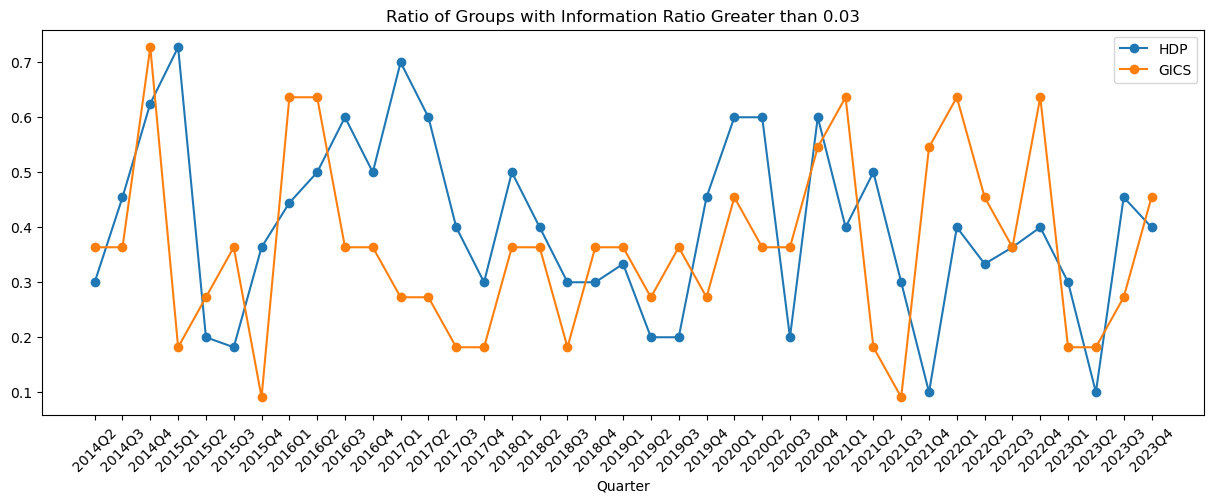

In [70]:
# get the number of elemnts in column[i] of var_df that is greater than market_return_var_lst[i]
num_greater_hdp = []
num_greater_gics = []
for i in range(i_r_df.shape[1]):
    num_greater_hdp.append(i_r_df[i_r_df.columns[i]][i_r_df[cvar_df.columns[i]] > 0.03].count() / i_r_df[i_r_df.columns[i]].count())
    num_greater_gics.append(gics_i_r_df[gics_i_r_df.columns[i]][gics_i_r_df[gics_i_r_df.columns[i]] > 0.03].count() / gics_i_r_df[gics_i_r_df.columns[i]].count())

# plot for both hdp and gics
plt.figure(figsize=(15, 5))
plt.plot(str_qt, num_greater_hdp, marker='o', label='HDP')
plt.plot(str_qt, num_greater_gics, marker='o', label='GICS')
plt.xticks(rotation=45)
plt.title('Ratio of Groups with Information Ratio Greater than 0.03')
plt.xlabel('Quarter')
plt.legend()
plt.show()

In [71]:
gics_s_r_df = pd.DataFrame(gics_sharpe_ratio_lst).transpose()
# rename columns of s_r_df to quarter_lst
gics_s_r_df.columns = quarter_lst[1:]
# # add market_sharpe_ratio_lst to the row of below s_r_df
# s_r_df.loc[11] = market_sharpe_ratio_lst
# color the cells with values above market_sharpe_ratio_lst
gics_s_r_df.style.apply(lambda x: ["background: lightgreen" if v > market_sharpe_ratio_lst[i] else "" for i, v in enumerate(x)], axis = 1)

,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,0.232058,-0.193090,-0.099895,-0.029862,-0.059934,-0.167218,-0.064721,-0.090838,-0.042022,-0.165628,-0.262872,-0.791677,-1.081328,-1.291254,-1.518223,-1.146069,-1.312284,-2.261850,-1.502108,-1.882704,-2.061151,-1.568563,-1.252293,-0.390162,0.118439,-0.191617,0.123584,0.187669,0.063597,-0.052636,0.010520,0.110312,-0.428021,-1.152663,-1.940011,-2.685516,-3.648149,-4.378120,-4.168038
1,0.070356,-0.033190,-0.000938,-0.004272,-0.033599,-0.221447,0.011678,-0.112339,-0.170801,-0.266423,-0.457959,-0.692367,-1.139996,-1.557722,-2.004339,-1.210496,-1.713119,-2.513602,-1.659509,-1.974484,-2.127967,-1.941360,-2.024600,-0.390778,0.141775,0.072814,0.113821,0.095700,0.045139,-0.105644,0.160317,-0.219213,-0.775164,-1.880146,-2.208716,-3.439195,-4.783724,-6.206075,-5.065656
2,0.029325,-0.076816,0.114324,-0.032319,-0.066358,-0.118764,-0.003861,-0.137397,-0.232821,-0.292748,-0.410193,-0.837241,-1.314321,-1.873463,-1.926757,-1.185040,-1.912296,-2.498572,-1.651218,-1.988233,-2.340180,-1.796700,-1.956591,-0.386327,0.091031,0.075717,0.118353,0.163852,0.054550,-0.125941,0.064563,-0.273179,-0.841900,-1.995094,-2.679002,-4.108814,-4.869148,-7.604027,-5.824037
3,0.009905,-0.047282,0.150048,0.076876,0.033778,-0.063383,-0.034289,-0.172545,-0.285856,-0.370466,-0.530848,-1.056032,-1.477086,-1.802857,-2.216550,-1.206539,-1.990742,-3.278558,-1.405607,-2.236323,-2.561235,-1.831714,-2.465258,-0.414448,0.197104,0.101450,0.043890,0.041018,0.080758,-0.040132,0.126250,-0.235186,-0.563936,-1.323444,-2.106339,-2.812430,-4.288671,-4.635472,-4.263622
4,0.079027,-0.002500,0.155968,0.002667,-0.079752,-0.054545,0.003196,-0.201389,-0.245628,-0.485143,-0.635880,-1.098044,-1.777784,-2.217805,-2.006932,-1.683346,-2.218064,-3.078193,-2.095678,-3.257296,-3.274299,-2.256914,-2.959009,-0.395307,0.024316,0.053385,-0.006205,0.004030,0.050952,-0.093339,0.182177,-0.327510,-0.800988,-2.933108,-3.766422,-5.440168,-8.372792,-8.951719,-6.550454
5,0.042585,0.060288,0.102371,0.081451,0.065006,-0.144767,0.013090,-0.275702,-0.171350,-0.410914,-0.513925,-0.843258,-1.497498,-1.690249,-2.255997,-1.226886,-2.060983,-3.529234,-1.633311,-2.416653,-2.651691,-2.366284,-1.908119,-0.385102,0.089569,-0.024096,0.042290,0.022803,0.177402,-0.047456,0.158271,-0.288602,-0.810060,-2.415890,-3.461461,-5.708204,-7.229496,-8.263695,-6.926728
6,0.008070,0.008061,0.122566,-0.048547,0.016622,-0.114553,-0.019331,-0.215688,-0.175627,-0.267486,-0.089512,-0.590714,-0.913531,-1.294641,-1.571461,-1.022814,-1.892049,-2.492446,-1.656685,-2.254557,-2.437768,-1.684937,-1.829797,-0.360299,0.065302,-0.010549,0.153803,0.169482,0.088203,-0.007647,-0.000137,-0.209586,-0.821158,-1.941205,-2.481923,-3.319288,-5.132795,-7.315304,-5.773614
7,0.095286,0.013532,0.093792,0.014120,-0.007610,-0.099118,0.011354,-0.105548,-0.126249,0.047581,-0.283987,-0.488272,-0.702913,-0.781548,-1.076334,-0.776064,-1.253999,-1.752278,-1.080831,-1.088444,-1.331296,-1.139540,-1.032404,-0.300140,0.159585,0.081936,0.155318,0.064977,0.034804,-0.034274,0.146171,-0.179319,-0.501562,-1.188694,-1.395419,-2.077383,-2.529955,-3.394588,-3.366927
8,-0.049268,-0.076153,0.084319,0.006679,-0.048850,-0.133148,0.005555,-0.115904,-0.183584,-0.084472,-0.337138,-0.750017,-0.826982,-1.258703,-1.475892,-1.266725,-1.947655,-2.281653,-1.478962,-1.881624,-2.189422,-1.587013,-1.826994,-0.388005,0.106702,-0.107649,0.240414,0.100160,0.103374,-0.126549,0.042655,-0.254945,-0.675164,-1.729070,-2.137518,-3.601193,-4.268896,-4.358537,-3.247275
9,0.121891,-0.088154,0.162275,-0.092871,-0.142364,0.028541,-0.080653,-0.037316,-0.182611,-0.376668,-0.344493,-0.655775,-1.763840,-1.704866,-1.840685,-1.549379,-2.140102,-2.434711,-1.988625,-2.980441,-2.772750,-2.692370,-2.489529,-0.295427,0.014370,-0.043960,-0.004037,0.040283,-0

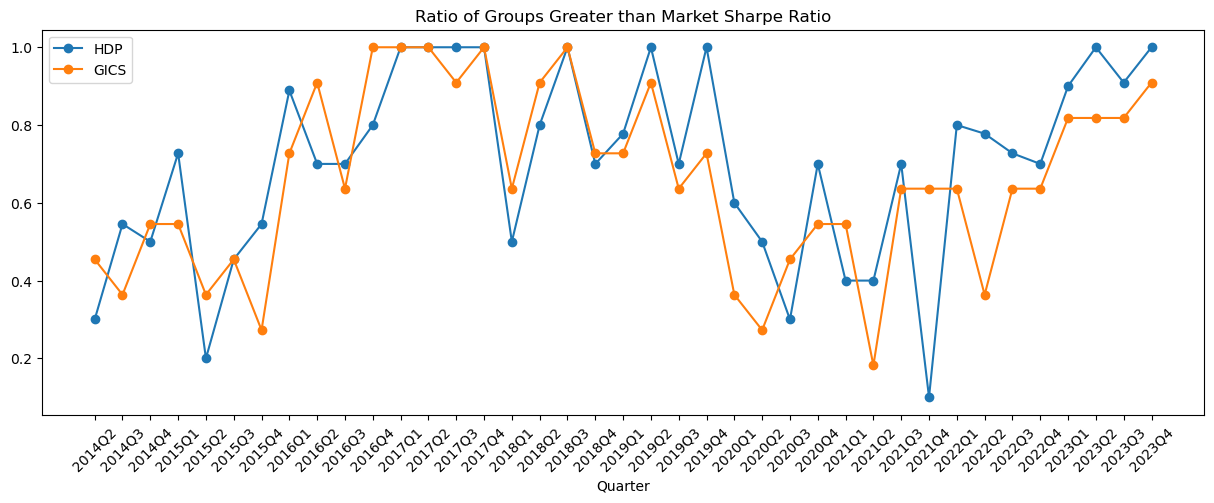

In [72]:
# get the number of elemnts in column[i] of var_df that is greater than market_return_var_lst[i]
num_greater_hdp = []
num_greater_gics = []
for i in range(s_r_df.shape[1]):
    num_greater_hdp.append(s_r_df[s_r_df.columns[i]][s_r_df[s_r_df.columns[i]] > market_sharpe_ratio_lst[i]].count() / s_r_df[s_r_df.columns[i]].count())
    num_greater_gics.append(gics_s_r_df[gics_s_r_df.columns[i]][gics_s_r_df[gics_s_r_df.columns[i]] > market_sharpe_ratio_lst[i]].count() / gics_s_r_df[gics_s_r_df.columns[i]].count())

# plot for both hdp and gics
plt.figure(figsize=(15, 5))
plt.plot(str_qt, num_greater_hdp, marker='o', label='HDP')
plt.plot(str_qt, num_greater_gics, marker='o', label='GICS')
plt.xticks(rotation=45)
plt.title('Ratio of Groups Greater than Market Sharpe Ratio')
plt.xlabel('Quarter')
plt.legend()
plt.show()

### For PyLDAvis visualization

In [386]:
# pyLDAvis for the models
hdp = hdp_model_lst[-2] # i is from 0 to 15 total of 15 periods
prepared_data = prepare_pyldavis_hdp(hdp)
pyLDAvis.display(prepared_data)

이것으로 무엇을 할 것인가?
# Analysis of topic modeling for stock stock price movement - concentration on S&P 500 and hierarchical dirichlet process (HDP) for topic modeling

## 1.
* 각 그룹별로 산업색인의 분포를 알아본다
* s&p 산업색인과 비교한다 (토픽의 개수가 비슷)
## 2.
* 그룹별로 sharpe/ir를 계산한다.
* 그룰별로 성과를 비교한다. (return, sharpe, ir 등등)
* s&p 산업지수와 움직임을 비교한다 (토픽의 개수가 비슷, 가장 많은 비중을 차지하는 토픽을 비교)
## 3.
* 그룹별로 within group 상관관계 계산을 한다 (return, sharpe, ir 등등)
* 상관관계 heatmap을 통해 sentimental analysis와 주가 추이가 어떤 관계가 있는지 알아본다.
* see if clustering is made available
## 4. 
* Comparison with LDA using coherence score and perplexity
    * Comparison with number of topics
    * Comparison with performance measures
## 5. Conclusion
* 

* Question: Why HDP?
* Answer: HDP is a non-parametric model, which means that the number of topics does not need to be specified in advance. This is a good feature for our analysis because we do not know the number of topics in advance.
The optimal number of topics can vary based on the 